# PyTorch workflow

Let's explore and example PyTorch end-to-end workflow

In [1]:
what_were_covering = {1: "data (prepare and load)",
                      2: "build model",
                      3: "fitting the model to data (training)",
                      4: "making predictions and evaluating model (inference)",
                      5: "saving and loading a model",
                      6: "putting it all together"}
what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluating model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [2]:
import torch
from torch import nn # nn contains all of Pytorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.4.0+cu121'

## 1. Data (preparing and loading)

* Excel spreadsheet
* Images of any kind
* Videos
* Audios like songs or podcasts
* DNA
* Text

Overall, machine learning is a game of two parts:

1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.

To showcase this, let's create some *known* data using the linear regression formula.

We'll use a linear regression formula to make a straight line with *known* **parameters**.


In [3]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim = 1)
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

### Splitting data into training and testing sets


In [4]:
# Create train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

Visualising the data

In [5]:
def plot_predictions(train_data = X_train,
                     train_label = y_train,
                     test_data = X_test,
                     test_label = y_test,
                     predictions = None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize = (10, 7))

  # Plot the training data in blue
  plt.scatter(train_data, train_label, c = "b", s = 4, label = "Training data")

  # Plot the testing data in green
  plt.scatter(test_data, test_label, c = "g", s = 4, label = "Testing data")

  # Are there predictions?
  if predictions is not None:
    # Plot the predictions in red, if they exist
    plt.scatter(test_data, predictions, c = "r", s = 4, label = "Predictions")

  # Show the legend
  plt.legend(prop = {"size": 14})

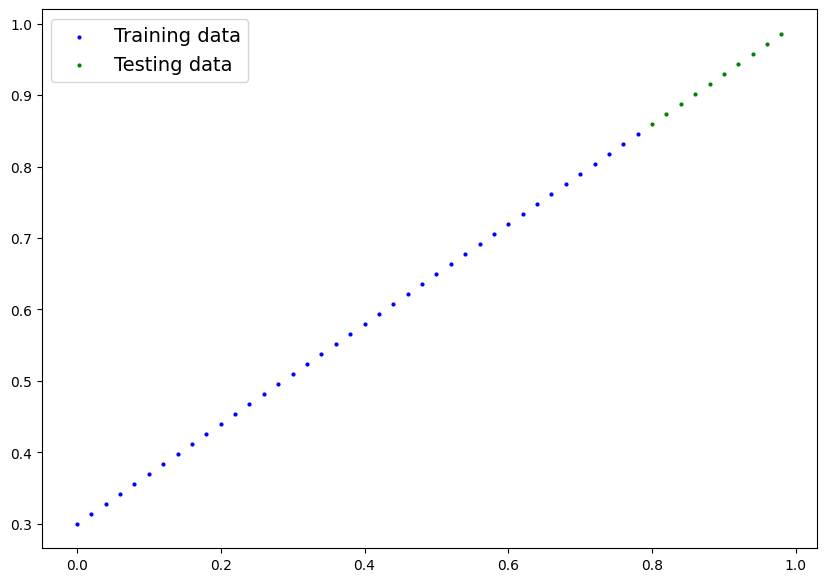

In [6]:
plot_predictions();

## 2. Build model


OOPs will be hoghly used in modelling part, have a refresh of OOPs in Python from here: https://realpython.com/python-classes/

What our model does:
* Start with random values (weights and biases)
* Look at training data and adjusts the random vlaues to better represent (or get closer to) the ideal values (the weight and biases values we used to create the data).

How does it do so?
1. Gradient descent
2. Backpropagation  

In [7]:
# Create linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherits from nn.Module
   def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad= True,
                                            dtype = torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad= True,
                                         dtype= torch.float))
    # Forward method to define the computation in the model
   def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data and "-> torch.Tensor" means that the function will return a tensor
    return self.weights * x + self.bias # This is the linear regression formula

### PyTorch model building essentials
* torch.nn: Contains all of the building blocks for computational graphs (a neural network can be considered a computational graph)
* torch.nn.Parameter: What parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module: the base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim: This where the optimizers in PyTorch live, they will help with gradient descent
* def forward(): All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation.
* torch.utils.data.Dataset: Represents a map between label and feature pairs of your data. Such as images and their associated labels.
* torch.utils.data.DataLoader: Allows you to iterate over your data

A bird's eye view:
1. Getting data ready: `torchvision.transform`, `torch.utils.data.Dataset`, `torch.utils.data.DataLoader`
2. Building or picking a pretrained model:
  * Picking loss function: `torch.nn`, `torch.nn.Module`, `torchvision.models`
  * Picking optimizer: `torch.optim`
3. Evaluating the model: `torchmetrics`
4. Improving through experimentation: `torch.utils.tensorboard`

### Checking the contents of our PyTorch model

We can check out model's parameters or what's inside our model using `.parameters()`

In [8]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model
model_0 = LinearRegressionModel()

# Check out the parameters
model_0

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`


To check the model's current predictive power, let's see how well it predicts `y_test` based on `X_test`

When we pass our data through our model, it's going to run it through the `forward()` method

In [10]:
y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

In [11]:
with torch.no_grad():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [12]:
# Make predictions with out model
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

More insights into the inference mode: https://x.com/PyTorch/status/1437838231505096708?lang=en


Overall, it is better to use inference mode as it leads to less number of back door calculations, and hence we can get the predictions faster.

In [13]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

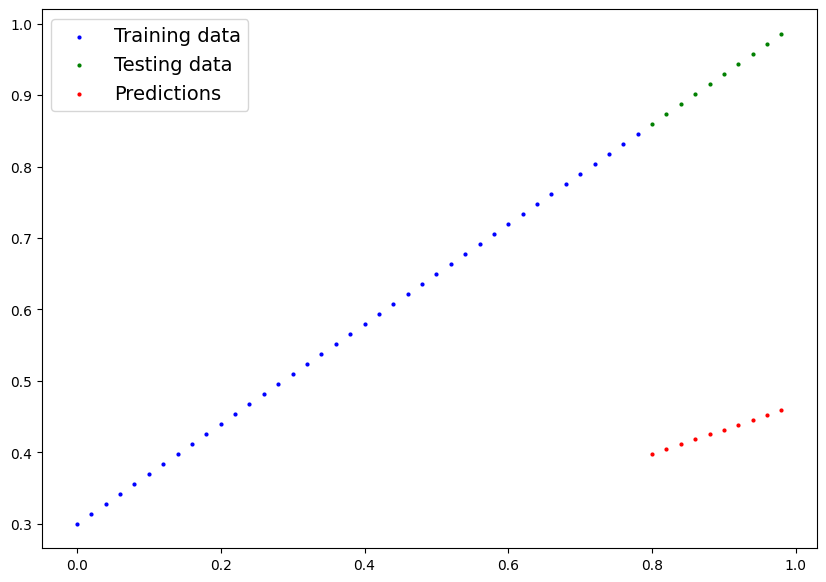

In [14]:
plot_predictions(predictions = y_preds)

## 3. Train model

The whole idea of training is for a model to moce from some *unknown * parameters (these may be random) to some *known* parameters.

Or in other words from a poor representation of data to a better represenation of data.

One way to measure how poor or how wrong your model's predictions are is to use a loss funciton.

Things we need to train a model:
* **Loss function**: A function to measure how wrong your model's predictions are to the ideal outputs, lower the loss function the better. In some cases, loss functions might also be referred to as `cost functions` or `criterion`

* **Optimizer**: Takes into account the loss of a mdoel and adjusts the model's parameters (e.g. weights and bias in our case) to improve the loss function. In optimizer you'll have to set two parameters:
  * `params`: the model parameters you'd like to optimize for example params = `model_0.parameters()`
  * `lr (learning rate)`: the learning rate is a hyperparameter that defines how big/small the optimizer changes the parameters with each step (a small `lr` results in small changes, a large `lr` results in large change.  

Specifically for PyTorch models, we need:
* A training loop
* A testing loop

In [15]:
# Check out our model's parameters (a parameters is a value that the model sets for itself)

model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [16]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer function
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.01) # learning rate is one of the most important hyperparameter of the modelling process. Hyperparameter is a value that we as machine learning practitioner set for the model.

In [17]:
loss_fn

L1Loss()

### Building a training loop and testing loop in PyTorch

A couple of things we need in a training loop:
0. Loop through data
1. Forward pass (this involves data moving through our model's `forward()` functions) to make predictions on data - also called as forward propagations.
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backward through the network to calculate the gradients of each of the parameters of our model with respect to the loss (backpropagation)
5. Optimizer step: use the optimizer to adjust our model's parameters to try and improve the loss (gradient descent)

In [18]:
# An epoch is one loop through the data
epoch = 200

# Track different values
epochs_count = []
loss_values = []
test_loss_values = []

### Training
# 0. Loop through the data
for epoch in range(epoch):
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)
  # print(f"Loss: {loss}")

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss wrt the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will accumulate through the loop, so we have to zero them above in step 3 for the next iteration of the loop


  ### Testing
  model_0.eval() # Tell the mdoel we want to evaluate and not train, by doing so it turns off funcitonality used for training but not evaluation

  with torch.inference_mode(): # turns off gradient tracking and other things behind the scenes
    # 1. Do forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  # Print out regular updates
  if epoch % 10 == 0:
    epochs_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    # Print out our model state_dict()
    print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

In [19]:
  # # Print out our model state_dict() after 10 epochs
  # model_0.state_dict()
  # Loss: 0.06395438313484192

In [20]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [21]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)
y_preds_new

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

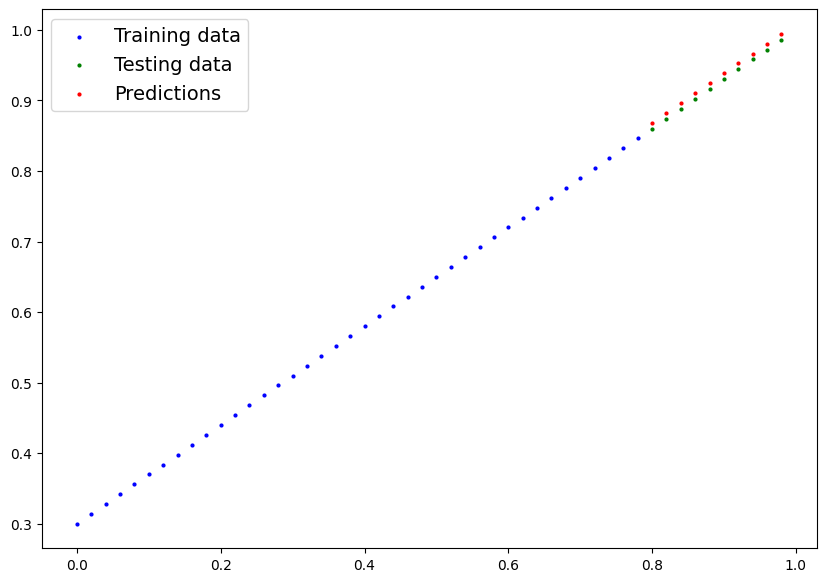

In [22]:
plot_predictions(predictions = y_preds_new)

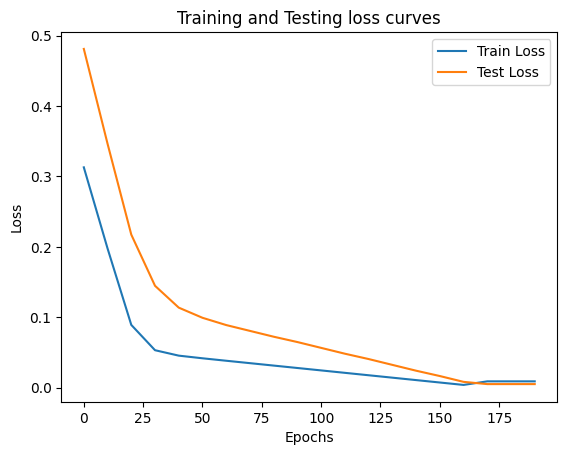

In [23]:
import numpy as np
# Plot loss curves
plt.plot(epochs_count, np.array(torch.tensor(loss_values).cpu().numpy()), label = "Train Loss")
plt.plot(epochs_count, test_loss_values, label = "Test Loss")
plt.title("Training and Testing loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

## Saving a model in PyTorch

There are three main methods which will be used:

1. `torch.save()` - allows you to save a PyTorch object in Python's pickle format
2. `torch.load()` - allows you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows to load a model's saved state dictionary

In [24]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [25]:
# Saving our PyTorch modl
from pathlib import Path

# 1. Create model's directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok= True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model_state_dict()
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_0.state_dict(),
           f = MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model.pth


In [26]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1668 Sep 16 00:06 01_pytorch_workflow_model.pth


## Loading a PyTorch model

Since we saved our model's `sate_dict()` rather than the entire model, we'll create a new instance of the our model class and load the saved `state_dict()` into it.

In [27]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [28]:
# To load in a saved state_dict() we have to instantiate a new instnace of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_sict of model_0 (this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f = MODEL_SAVE_PATH))

<ipython-input-28-e7944e95c520>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f = MODEL_SAVE_PATH))


<All keys matched successfully>

In [29]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [30]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [31]:
# Make some predictions with the loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [32]:
# Compare loaded model preds with original model preds
y_preds_new == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

Let's put all of the things we learnt above together

In [33]:
from sys import version
# Import dependencies
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check torch version
torch.__version__

'2.4.0+cu121'

Create device-agnostinc code.

This means if we've got access to a GPU, our code will use it (for potentially faster computing)

In [34]:
# Setup device agnostinc code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


In [35]:
!nvidia -smi

/bin/bash: line 1: nvidia: command not found


### 6.1 Data

In [36]:
# Create some data using linear regression formula of y = weight* X + bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y
X = torch.arange(start, end, step).unsqueeze(dim = 1) # without unsqueeze, errors are encountered.
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [37]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

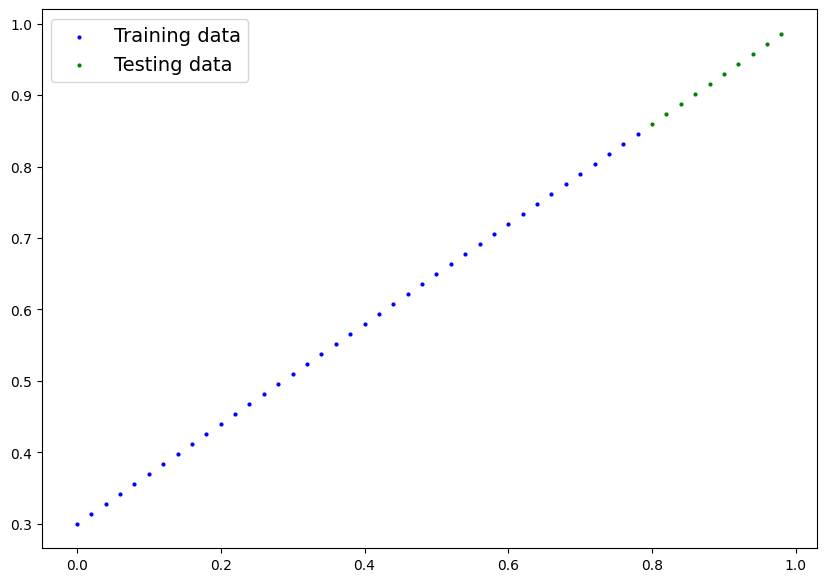

In [38]:
# Plot the data
plot_predictions(X_train, y_train, X_test, y_test)

### 6.2 Building a PyTorch linear model

In [39]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters, aka linear transform, probing layer, fully connected layer, dense layer
    self.linear_layer = nn.Linear(in_features= 1,
                                  out_features=1) # in_feature means how many input features do we have and out_feature means how many output features do we have i.e. we have one value of X and one value as y
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# Set the manual seed
torch.manual_seed(42)

# Initialise the model
model_1 = LinearRegressionModelV2()
model_1
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

In [40]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [41]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.3 Training

For training:
* Loss function
* Optimizer
* Training Loop
* Testing Loop

In [42]:
# Setup loss function
loss_fn = nn.L1Loss()

# Setup optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr = 0.01)

In [43]:
# Training loop
torch.manual_seed(42)

epochs = 200

# Put the data on the target device (device agnostic code)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation
  loss.backward()

  # Optimizer step
  optimizer.step()

  ### Testing phase
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fn(test_pred, y_test)

  # Print out ehat's happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")
    # print(f"\nmodel_1.state_dict(): {model_1.state_dict()}")

Epoch: 0 | Loss: 0.5551779866218567 | Test Loss: 0.5739762187004089
Epoch: 10 | Loss: 0.439968079328537 | Test Loss: 0.4392664134502411
Epoch: 20 | Loss: 0.3247582018375397 | Test Loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954833924770355 | Test Loss: 0.16984669864177704
Epoch: 40 | Loss: 0.09433845430612564 | Test Loss: 0.03513690456748009
Epoch: 50 | Loss: 0.023886388167738914 | Test Loss: 0.04784907028079033
Epoch: 60 | Loss: 0.019956795498728752 | Test Loss: 0.045803118497133255
Epoch: 70 | Loss: 0.016517987474799156 | Test Loss: 0.037530567497015
Epoch: 80 | Loss: 0.013089174404740334 | Test Loss: 0.02994490973651409
Epoch: 90 | Loss: 0.009653178043663502 | Test Loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215683650225401 | Test Loss: 0.014086711220443249
Epoch: 110 | Loss: 0.00278724217787385 | Test Loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test Loss: 0.013801801018416882
Epoch: 130 | Loss: 0.0012645035749301314 | Test Loss: 0.013801801018416

In [44]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [45]:
weight, bias

(0.7, 0.3)

### 6.4 Making and evaluating predictions

In [46]:
# Turn model into inference mode
with torch.inference_mode():
  y_preds = model_1(X_test)

y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

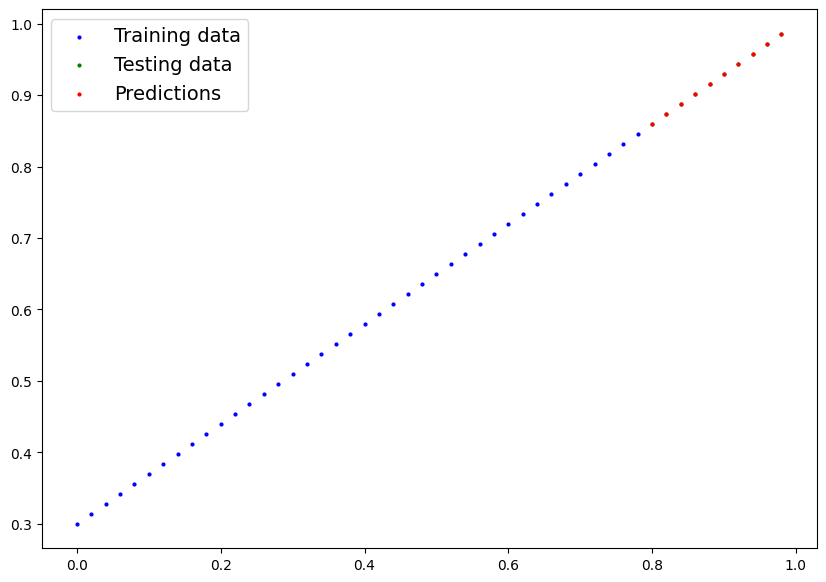

In [47]:
# Check out the model's predicitons visually
plot_predictions(predictions = y_preds.cpu())

### 6.5 Saving and loading a trained model

In [48]:
from pathlib import Path

# 1. Create model's directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

# 3. Save the model state_dict()
print(f"SAving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_1.state_dict(),
           f = MODEL_SAVE_PATH)

SAving model to: models/01_pytorch_workflow_model_1.pth


In [49]:
# Load a PyTorch model

# Create a new instanc eof linear regression model V2
loaded_model_1 = LinearRegressionModelV2()

# Load the saved model_1 state_dict()
loaded_model_1.load_state_dict(torch.load(f = MODEL_SAVE_PATH))

# Put the loaded model to device
loaded_model_1.to(device)

<ipython-input-49-d62b4058006c>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(f = MODEL_SAVE_PATH))


LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [50]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [51]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [52]:
# Evaluate the loaded model
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)

y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')